# 2 Feature Engineering

## 2-1 根據基本總分產生的初步TCRI等級

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("data/TCRI_2008_2017_prob.csv", encoding="utf-8")
df["c_0"] = df["c_0"].astype(float)  # 讀取後將欄位弄成float
df["c_1"] = df["c_1"].astype(float)
df["c_2"] = df["c_2"].astype(float)
df["c_3"] = df["c_3"].astype(float)
df["c_4"] = df["c_4"].astype(float)
df["TCRI"] = df["TCRI"].astype(float)
print(df.shape)
df.tail(2)

(2288, 20)


,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,1.0,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


In [3]:
def transformBasicTCRILevel(value):
    level = 0
    if value < 165.0:
        level = 9
    elif value < 250.0:
        level = 8
    elif value < 335.0:
        level = 7
    elif value < 420.0:
        level = 6
    elif value < 505.0:
        level = 5
    elif value < 590.0:
        level = 4
    elif value < 675.0:
        level = 3
    elif value < 760.0:
        level = 2
    else:
        level = 1
    return level

In [4]:
basicTCRI = []
for score in df['總分']:
    basicTCRI.append(transformBasicTCRILevel(score))

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(basicTCRI, df['TCRI']))
print(rmse)

2.3138757483972596


In [6]:
# 用初步等級將總分替換
# df.drop(['總分'], axis=1, inplace=True)
df['初步等級'] = basicTCRI
df.head()

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,...,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級
0,1101 台泥,2008/12/31,3.0,622.0,80.43,0,3.51,2.93,6.64,3.72,...,-2.0,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3
1,1201 味全,2008/12/31,5.0,621.0,10.75,0,0.54,4.62,4.04,3.27,...,1.0,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3
2,1210 大成,2008/12/31,4.0,719.0,23.25,0,0.42,5.93,1.96,4.42,...,-9.0,43.0,712.0,2,0.0,0.0,0.0,0.0,0.0,2
3,1215 卜蜂,2008/12/31,4.0,582.0,1.77,0,0.27,5.49,2.37,3.73,...,-1.0,38.0,154.0,2,0.0,0.0,0.0,0.0,0.0,4
4,1216 統一,2008/12/31,4.0,618.0,178.78,0,1.38,4.02,4.95,3.56,...,1.0,125.0,2997.0,2,0.0,0.0,0.0,0.0,0.0,3


## 2-2 門檻等級：規模

In [7]:
thresholdLevel = []
for i in range(len(df)):
    rev = df['營收'].iloc[i]
    level = df['初步等級'].iloc[i]
    threshold = 0
    
    # 營收不到5億，則不列入前5等；電子業門檻較高，門檻為10億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 10
    else:
        threshold = 5
    if rev < threshold and level <= 5:
        level = 6
        
    # 營收不到10億，則不列入前4等；電子業門檻較高，門檻為20億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 20
    else:
        threshold = 10
    if rev < threshold and level <= 4:
        level = 5
    
    # 營收不到30億，則不列入前3等；電子業門檻較高，門檻為40億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 40
    else:
        threshold = 30
    if rev < threshold and level <= 3:
        level = 4
        
    # 營收不到100億，則不列入前2等
    threshold = 100
    if rev < threshold and level <= 2:
        level = 3
        
    # 營收不到200億，則不列入前1等
    threshold = 200
    if rev < threshold and level <= 1:
        level = 2
    
    # 補充電子業門檻較高原因：受景氣影響較深，除非擁有關鍵技術或特殊的利基市場、獨門生意，否則一律適用較嚴格的規模門檻。
    
    thresholdLevel.append(level)

df['門檻等級_規模'] = thresholdLevel
df.head()

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,...,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模
0,1101 台泥,2008/12/31,3.0,622.0,80.43,0,3.51,2.93,6.64,3.72,...,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3,3
1,1201 味全,2008/12/31,5.0,621.0,10.75,0,0.54,4.62,4.04,3.27,...,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3,3
2,1210 大成,2008/12/31,4.0,719.0,23.25,0,0.42,5.93,1.96,4.42,...,43.0,712.0,2,0.0,0.0,0.0,0.0,0.0,2,2
3,1215 卜蜂,2008/12/31,4.0,582.0,1.77,0,0.27,5.49,2.37,3.73,...,38.0,154.0,2,0.0,0.0,0.0,0.0,0.0,4,4
4,1216 統一,2008/12/31,4.0,618.0,178.78,0,1.38,4.02,4.95,3.56,...,125.0,2997.0,2,0.0,0.0,0.0,0.0,0.0,3,3


## 2-2 APL 財務壓力計

### 2-2-1 Assets Management

In [8]:
# # 確認有無離群值
# plt.subplot(1, 2, 1)
# plt.boxplot(df['平均收款天增減'])
# plt.subplot(1, 2, 2)
# plt.boxplot(df['平均售貨天增減'])
# plt.tight_layout()

In [9]:
from scipy import stats
index_temp_1 = df[(np.abs(stats.zscore(df['平均收款天增減'])) > 3)].index
index_temp_2 = df[(np.abs(stats.zscore(df['平均售貨天增減'])) > 3)].index
# display(index_temp_1)
# display(index_temp_2)

# 聯集：讓index不重複
def find_union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2)) 
    return final_list

index_to_drop = find_union(index_temp_1, index_temp_2)

df.drop(index=index_to_drop, axis=1, inplace=True)
df.head(2)

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,...,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模
0,1101 台泥,2008/12/31,3.0,622.0,80.43,0,3.51,2.93,6.64,3.72,...,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3,3
1,1201 味全,2008/12/31,5.0,621.0,10.75,0,0.54,4.62,4.04,3.27,...,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3,3


In [10]:
# plt.subplot(1, 2, 1)
# plt.boxplot(df['平均收款天增減'])
# plt.subplot(1, 2, 2)
# plt.boxplot(df['平均售貨天增減'])
# plt.tight_layout()

In [11]:
# A1. 平均收帳天數比前一期慢 >= 20 天
# df[df['平均收款天增減'] >= 20]
A1 = []
for d in df['平均收款天增減']:
    if d >= 20:
        A1.append(int(d / 20))
    else:
        A1.append(0)
df['A1'] = A1

In [12]:
# A3. 平均售貨天數比前一期慢 >= 20 天
A3 = []
for d in df['平均售貨天增減']:
    if d >= 20:
        A3.append(int(d / 20))
    else:
        A3.append(0)
df['A3'] = A3

### 2-2-2 Profitability

In [13]:
# P1. 當期的總資產報酬率(ROA)不敷借款息
# df[df['資產報酬%'] - df['借款息%'] <= 0]
P1 = []
for i in range(len(df)):
    if df['資產報酬%'].iloc[i] - df['借款息%'].iloc[i] <= 0:
        P1.append(True)
    else:
        P1.append(False)

In [14]:
# P2. 當期的營業利益率(OP%)不足支應利息支出率(INT%)
# df[df['營業利益%'] - df['利息支出率'] <= 0]
P2 = []
for i in range(len(df)):
    if df['營業利益%'].iloc[i] - df['利息支出率'].iloc[i] <= 0:
        P2.append(True)
    else:
        P2.append(False)

In [15]:
'''
P發生的case
(1) P1且P2
(2) 連續3期P1（先略過）
'''
P_case1 = []
for i in range(len(df)):
    if P1[i] and P2[i]:
        P_case1.append(1)
    else:
        P_case1.append(0)
df['P'] = P_case1
df.head()

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,...,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P
0,1101 台泥,2008/12/31,3.0,622.0,80.43,0,3.51,2.93,6.64,3.72,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0
1,1201 味全,2008/12/31,5.0,621.0,10.75,0,0.54,4.62,4.04,3.27,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0
2,1210 大成,2008/12/31,4.0,719.0,23.25,0,0.42,5.93,1.96,4.42,...,0.0,0.0,0.0,0.0,0.0,2,2,0,0,0
3,1215 卜蜂,2008/12/31,4.0,582.0,1.77,0,0.27,5.49,2.37,3.73,...,0.0,0.0,0.0,0.0,0.0,4,4,0,0,0
4,1216 統一,2008/12/31,4.0,618.0,178.78,0,1.38,4.02,4.95,3.56,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0


### 2-2-3 Liquidity

In [16]:
# L1. 借款依存度(DE%)超過100%
# df[df['借款依存度%'] > 100]
L1 = []
for l in df['借款依存度%']:
    if l > 100:
        L1.append(1)
    else:
        L1.append(0)
df['L1'] = L1

In [17]:
# L3. CFO為負，不足資金 < -0.25億
# df[df['CFO'] < -0.25]
L3 = []
for l in df['CFO']:
    if l < 0.25:
        L3.append(1)
    else:
        L3.append(0)
df['L3'] = L3

### 把TCRI等級量化

In [18]:
df["score"] = 0.0
df.loc[df['TCRI'] ==  0.0, 'score'] = 110.0
df.loc[df['TCRI'] ==  9.0, 'score'] = 110.0
df.loc[df['TCRI'] ==  8.0, 'score'] = 215.0
df.loc[df['TCRI'] ==  7.0, 'score'] = 300.0
df.loc[df['TCRI'] ==  6.0, 'score'] = 385.0
df.loc[df['TCRI'] ==  5.0, 'score'] = 470.0
df.loc[df['TCRI'] ==  4.0, 'score'] = 555.0
df.loc[df['TCRI'] ==  3.0, 'score'] = 640.0
df.loc[df['TCRI'] ==  2.0, 'score'] = 725.0
df.loc[df['TCRI'] ==  1.0, 'score'] = 810.0

### 把初步等級量化

In [19]:
# df["score_first"] = 0.0
# df.loc[df['初步等級'] ==  0.0, 'score_first'] = -50.0
# df.loc[df['初步等級'] ==  9.0, 'score_first'] = 50.0
# df.loc[df['初步等級'] ==  8.0, 'score_first'] = 165.0
# df.loc[df['初步等級'] ==  7.0, 'score_first'] = 300.0
# df.loc[df['初步等級'] ==  6.0, 'score_first'] = 400.0
# df.loc[df['初步等級'] ==  5.0, 'score_first'] = 500.0
# df.loc[df['初步等級'] ==  4.0, 'score_first'] = 600.0
# df.loc[df['初步等級'] ==  3.0, 'score_first'] = 700.0
# df.loc[df['初步等級'] ==  2.0, 'score_first'] = 800.0
# df.loc[df['初步等級'] ==  1.0, 'score_first'] = 900.0

In [20]:
df.head()

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,...,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P,L1,L3,score
0,1101 台泥,2008/12/31,3.0,622.0,80.43,0,3.51,2.93,6.64,3.72,...,0.0,0.0,3,3,0,0,0,0,0,640.0
1,1201 味全,2008/12/31,5.0,621.0,10.75,0,0.54,4.62,4.04,3.27,...,0.0,0.0,3,3,0,0,0,0,0,470.0
2,1210 大成,2008/12/31,4.0,719.0,23.25,0,0.42,5.93,1.96,4.42,...,0.0,0.0,2,2,0,0,0,0,0,555.0
3,1215 卜蜂,2008/12/31,4.0,582.0,1.77,0,0.27,5.49,2.37,3.73,...,0.0,0.0,4,4,0,0,0,0,0,555.0
4,1216 統一,2008/12/31,4.0,618.0,178.78,0,1.38,4.02,4.95,3.56,...,0.0,0.0,3,3,0,0,0,1,0,555.0


### 去掉跟regression無關的欄位

In [21]:
df = df.drop(['總分','CFO不一致','TSE產業別','初步等級','門檻等級_規模', 'A1','A3','P','L1','L3'], axis = 1)
print(df.shape)
df.head()

(2258, 18)


,公司,年月,TCRI,CFO,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,c_0,c_1,c_2,c_3,c_4,score
0,1101 台泥,2008/12/31,3.0,80.43,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0,0.0,0.0,0.0,0.0,0.0,640.0
1,1201 味全,2008/12/31,5.0,10.75,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0,0.0,0.0,0.0,0.0,0.0,470.0
2,1210 大成,2008/12/31,4.0,23.25,0.42,5.93,1.96,4.42,-5.0,-9.0,43.0,712.0,0.0,0.0,0.0,0.0,0.0,555.0
3,1215 卜蜂,2008/12/31,4.0,1.77,0.27,5.49,2.37,3.73,0.0,-1.0,38.0,154.0,0.0,0.0,0.0,0.0,0.0,555.0
4,1216 統一,2008/12/31,4.0,178.78,1.38,4.02,4.95,3.56,-1.0,1.0,125.0,2997.0,0.0,0.0,0.0,0.0,0.0,555.0


# 3 訓練前的準備

## 3-1 Resample imbalanced labels
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [22]:
df['TCRI'].value_counts()

4.0    509
5.0    440
6.0    398
7.0    270
3.0    206
8.0    168
9.0    102
0.0     80
2.0     45
1.0     40
Name: TCRI, dtype: int64

In [23]:
# df['TCRI'].value_counts().plot(kind='bar')

In [24]:
# Class count
count_TCRI_4 = 2*len(df[df['TCRI'] == 4])


# Divide by class
df_TCRI_0 = df[df['TCRI'] == 0.0]
df_TCRI_1 = df[df['TCRI'] == 1]
df_TCRI_2 = df[df['TCRI'] == 2]
df_TCRI_3 = df[df['TCRI'] == 3]
df_TCRI_4 = df[df['TCRI'] == 4]
df_TCRI_5 = df[df['TCRI'] == 5]
df_TCRI_6 = df[df['TCRI'] == 6]
df_TCRI_7 = df[df['TCRI'] == 7]
df_TCRI_8 = df[df['TCRI'] == 8]
df_TCRI_9 = df[df['TCRI'] == 9]

In [25]:
# 把每個類別都複製到跟4類別一樣多

df_TCRI_0_over = df_TCRI_0.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_1_over = df_TCRI_1.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_2_over = df_TCRI_2.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_3_over = df_TCRI_3.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_4_over = df_TCRI_4.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_5_over = df_TCRI_5.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_6_over = df_TCRI_6.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_7_over = df_TCRI_7.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_8_over = df_TCRI_8.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_9_over = df_TCRI_9.sample(n=count_TCRI_4, replace=True, random_state=2018, )

In [26]:
# 新的複製的data 合併
df_resample = pd.concat([df_TCRI_0_over, df_TCRI_1_over, df_TCRI_2_over, df_TCRI_3_over, df_TCRI_4_over, df_TCRI_5_over, df_TCRI_6_over, df_TCRI_7_over, df_TCRI_8_over, df_TCRI_9_over])
df_resample['TCRI'].value_counts()

9.0    1018
8.0    1018
7.0    1018
6.0    1018
5.0    1018
4.0    1018
3.0    1018
2.0    1018
1.0    1018
0.0    1018
Name: TCRI, dtype: int64

In [27]:
# df_resample['TCRI'].value_counts().plot(kind='bar')

## 4 訓練Multivariate Adaptive Regression Splines模型 求feature_importances_

In [28]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [29]:
Y = df['score'].values
X = df.drop(['score', 'TCRI', '公司', '年月'], axis = 1).values

# 標準化
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = minmax_scale.fit_transform(X)

print(X.shape)
print(Y.shape)

(2258, 14)
(2258,)


In [30]:
%%time

from pyearth.earth import Earth

criteria=('rss', 'gcv', 'nb_subsets')
model_earth = Earth(enable_pruning = True, penalty = 3
                 , minspan_alpha = 0.05
                 , endspan_alpha = 0.05
                 , allow_missing=True
                 , feature_importance_type=('rss', 'gcv', 'nb_subsets'))

model_earth.fit(X, Y)

/home/barry/miniconda3/envs/bertenv3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


CPU times: user 4.59 s, sys: 84 ms, total: 4.67 s
Wall time: 806 ms


/home/barry/miniconda3/envs/bertenv3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(allow_linear=None, allow_missing=True, check_every=None,
      enable_pruning=True, endspan=None, endspan_alpha=0.05, fast_K=None,
      fast_h=None, feature_importance_type=('rss', 'gcv', 'nb_subsets'),
      max_degree=None, max_terms=None, min_search_points=None, minspan=None,
      minspan_alpha=0.05, penalty=3, smooth=None, thresh=None, use_fast=None,
      verbose=0, zero_tol=None)

In [ ]:
importances = model_earth.feature_importances_

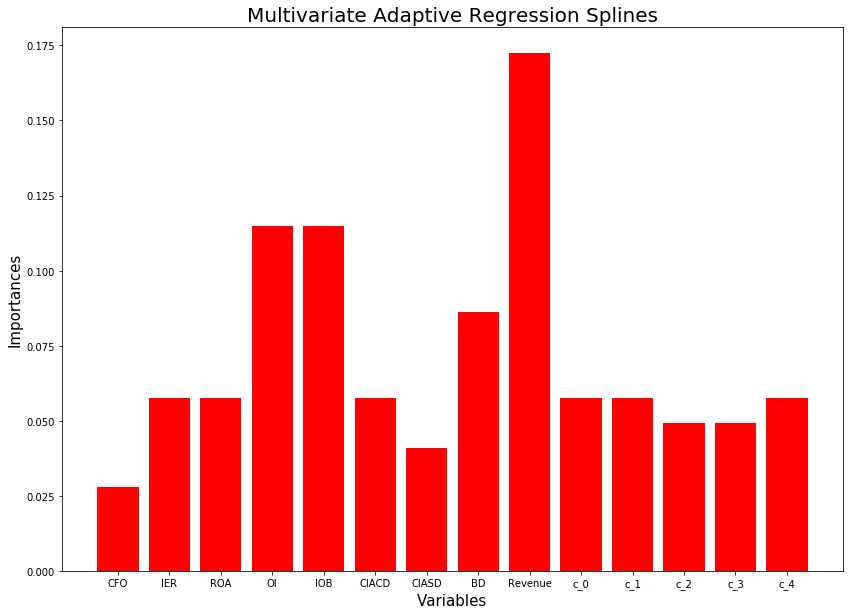

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(14, 10))
labels = ['CFO', 'IER', 'ROA', 'OI', 'IOB', 'CIACD', 'CIASD','BD', 'Revenue', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4']
plt.bar(np.arange(len(labels)), importances['nb_subsets'], align='center', color='red')
plt.title('Multivariate Adaptive Regression Splines', fontsize=20)
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Importances', fontsize=15)
plt.xlabel('Variables', fontsize=15)
plt.show()

In [33]:
df.drop(['score', 'TCRI', '公司', '年月'], axis = 1).columns.values

array(['CFO', '利息支出率', '資產報酬%', '營業利益%', '借款息%', '平均收款天增減', '平均售貨天增減',
       '借款依存度%', '營收', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4'], dtype=object)